In [1]:
from pyteomics import fasta
import pandas as pd
import numpy as np
import re
import time
from datetime import datetime
import json
import os

In [2]:
#Data path
datadir = os.path.abspath("../../Data/")

# Data prep

In [18]:
import esm
import torch
import time
%run "../scripts/data_processing.py"
%run "../scripts/node_edge_generation.py"
%run "../scripts/graph_functions.py"

In [4]:
#Start graph
startGraph("./pass_ent.txt", "./Results/")

#Submit query, retrieve sequences
uri = "bolt://localhost:7687" 
driver = GraphDatabase.driver(uri)
query_1 = [f'match (p:Protein)\n \
            where not p.subcellular_location contains "[]" \
            return p.uniprot as Uniprot, p.subcellular_location as Subcellular_location, p.seq as Sequence']
results_1 = run_query(query_1[0], driver)
display(results_1)

#Close connection
driver.close()

Graph stopped
Database import successful!
Graph started


,Uniprot,Subcellular_location,Sequence
0,A2RRL7,[['membrane ; single-pass type i membrane prot...,MQRLPAATRATLILSLAFASLHSACSAEASSSNSSSLTAHHPDPGT...
1,A8MYZ6,"[['cytoplasm', 'nucleus']]",MAAKLRAHQVDVDPDFAPQSRPRSCTWPLPQPDLAGDEDGALGAGV...
2,O14804,[['cell membrane ; multi-pass membrane protein']],MRAVFIQGAEEHPAAFCYQVNGSCPRTVHTLGIQLVIYLACAAGML...
3,O75459,"[['nucleoli fibrillar center', 'mitochondria',...",MGFLRRLIYRRRPMIYVESSEESSDEQPDEVESPTQSQDSTPAEER...
4,O75912,"[['cell projection, axon', 'cell projection, d...",MDAAGRGCHLLPLPAARGPARAPAAAAAAAASPPGPCSGAACAPSA...
...,...,...,...
18417,O60218,"[['lysosome', 'secreted', 'cytosol', 'plasma m...",MATFVELSTKAKMPIVGLGTWKSPLGKVKEAVKVAIDAGYRHIDCA...
18418,O60336,"[['cytoplasm', 'nucleus', 'cytoplasm, cytoskel...",MAVEGSTITSRIKNLLRSPSIKLRRSKAGNRREDLSSKVTLEKVLG...
18419,O60733,"[['cytoplasm', 'cell membrane', 'mitochondrion...",MQFFGRLVNTFSGVTNLFSNPFRVKEVAVADYTSSDRVREEGQLIL...
18420,O60812,[['nucleus']],MASNVTNKMDPHSMNSRVFIGNLNTLVVKKSDVEAIFSKYGKIAGC...


In [16]:
# Load ESM-2 model
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()

In [30]:
#Split to test + train datasets
from sklearn.model_selection import train_test_split
print(len(results_1["Sequence"].values), len(results_1["Uniprot"].values))
train_sequences, test_sequences, train_labels, test_labels = train_test_split(results_1["Sequence"].values, results_1["Uniprot"].values, test_size=0.25, shuffle=True)
print(len(train_sequences), len(test_sequences))

18422 18422
13816 4606


In [12]:
#Prepare sequences for tokenisation
tuplist = []
for index, row in results_1.iterrows():
    tuplist.append((row["Uniprot"], row["Sequence"]))

for i in tuplist[0:10]:
    print(i)

('A2RRL7', 'MQRLPAATRATLILSLAFASLHSACSAEASSSNSSSLTAHHPDPGTLEQCLNVDFCPQAARCCRTGVDEYGWIAAAVGWSLWFLTLILLCVDKLMKLTPDEPKDLQA')
('A8MYZ6', 'MAAKLRAHQVDVDPDFAPQSRPRSCTWPLPQPDLAGDEDGALGAGVAEGAEDCGPERRATAPAMAPAPPLGAEVGPLRKAKSSRRNAWGNLSYADLITKAIESAPDKRLTLSQIYDWMVRYVPYFKDKGDSNSSAGWKNSIRHNLSLHTRFIRVQNEGTGKSSWWMLNPEGGKTGKTPRRRAVSMDNGAKFLRIKGKASKKKQLQAPERSPDDSSPSAPAPGPVPAAAKWAASPASHASDDYEAWADFRGGGRPLLGEAAELEDDEALEALAPSSPLMYPSPASALSPALGSRCPGELPRLAELGGPLGLHGGGGAGLPEGLLDGAQDAYGPRPAPRPGPVLGAPGELALAGAAAAYPGKGAAPYAPPAPSRSALAHPISLMTLPGEAGAAGLAPPGHAAAFGGPPGGLLLDALPGPYAAAAAGPLGAAPDRFPADLDLDMFSGSLECDVESIILNDFMDSDEMDFNFDSALPPPPPGLAGAPPPNQSWVPG')
('O14804', 'MRAVFIQGAEEHPAAFCYQVNGSCPRTVHTLGIQLVIYLACAAGMLIIVLGNVFVAFAVSYFKALHTPTNFLLLSLALADMFLGLLVLPLSTIRSVESCWFFGDFLCRLHTYLDTLFCLTSIFHLCFISIDRHCAICDPLLYPSKFTVRVALRYILAGWGVPAAYTSLFLYTDVVETRLSQWLEEMPCVGSCQLLLNKFWGWLNFPLFFVPCLIMISLYVKIFVVATRQAQQITTLSKSLAGAAKHERKAAKTLGIAVGIYLLCWLPFTIDTMVDSLLHFITPPLVFDIFIWFAYFNSACNPIIYVFSYQWFRKALKLTLSQKVFSPQTRTVDLYQE')
('O75459', 'MGFLRRL

In [20]:
#Tokenise + pad sequences
start = time.time()
batch_labels, batch_strs, batch_tokens = batch_converter(tuplist)
print(f"Time taken (Tokenisation) = {round(time.time()-start, 3)} seconds")

Time taken (Tokenisation) = 23.698


In [23]:
print(len(batch_labels), len(batch_strs), len(batch_tokens))
print(batch_tokens[0:10])

18422 18422 18422
tensor([[ 0, 20, 16,  ...,  1,  1,  1],
        [ 0, 20,  5,  ...,  1,  1,  1],
        [ 0, 20, 10,  ...,  1,  1,  1],
        ...,
        [ 0, 20, 11,  ...,  1,  1,  1],
        [ 0, 20,  9,  ...,  1,  1,  1],
        [ 0, 20, 12,  ...,  1,  1,  1]])


In [24]:
print("Tokenized sequences shape:", batch_tokens.shape)

Tokenized sequences shape: torch.Size([18422, 34352])


# Subcellular localisation prediction example

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

In [ ]:
'''
uniprot_proteomics_dataset.csv

protein_id,sequence_embedding,subcellular_location
P12345,"[0.1, 0.2, 0.3, 0.4, 0.5]",cytoplasm
Q67890,"[0.5, 0.4, 0.3, 0.2, 0.1]",nucleus
A11223,"[0.2, 0.3, 0.4, 0.5, 0.6]",mitochondrion
B33445,"[0.3, 0.2, 0.1, 0.4, 0.5]",plasma membrane
C55678,"[0.6, 0.5, 0.4, 0.3, 0.2]",extracellular region
'''

In [ ]:
#Step 2: Load and Preprocess the Dataset
# Load dataset
data = pd.read_csv("uniprot_proteomics_dataset.csv")

# Inspect dataset
print(data.head())

# Extract relevant features and labels
sequence_features = np.array(data["sequence_embedding"].apply(eval).tolist())  # Assuming embeddings are precomputed
labels = data["subcellular_location"]

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(sequence_features, encoded_labels, test_size=0.2, random_state=42)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [ ]:
#Step 3: Define the Neural Network
class ProteinClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(ProteinClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
#Step 4: Train the Model
# Initialize model, loss function, and optimizer
input_dim = X_train.shape[1]
num_classes = len(label_encoder.classes_)
model = ProteinClassifier(input_dim, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
batch_size = 32

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    num_batches = len(X_train_tensor) // batch_size

    for i in range(0, len(X_train_tensor), batch_size):
        # Get batch
        X_batch = X_train_tensor[i:i+batch_size]
        y_batch = y_train_tensor[i:i+batch_size]
        
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/num_batches:.4f}")


In [ ]:
#Step 5: Evaluate the Model
# Evaluation
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    accuracy = accuracy_score(y_test_tensor.numpy(), predicted.numpy())
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

In [ ]:
#Step 6: Save and Load the Model
# Save the model
torch.save(model.state_dict(), "protein_classifier.pth")

# Load the model
loaded_model = ProteinClassifier(input_dim, num_classes)
loaded_model.load_state_dict(torch.load("protein_classifier.pth"))
loaded_model.eval()

# Tutorials

## Resources

In [ ]:
Git
#https://github.com/liyu95/Deep_learning_examples/tree/master
#https://github.com/Moeinh77/blog_posts_codes/blob/main/pfam_esm.ipynb

Papers
#https://www.nature.com/articles/s41598-022-12201-9 | Prediction of protein–protein interaction using graph neural networks

Other
#https://medium.com/@moeinh77/protein-sequence-analyses-with-transformers-using-pytorch-and-huggingface-11a478bcc602
#https://huggingface.co/blog/AmelieSchreiber/protein-binding-partners-with-esm2

## Quickstart - PyTorch

In [2]:
#https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [3]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [4]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [5]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [7]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [8]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.304448  [   64/60000]
loss: 2.292910  [ 6464/60000]
loss: 2.273953  [12864/60000]
loss: 2.263016  [19264/60000]
loss: 2.247937  [25664/60000]
loss: 2.228266  [32064/60000]
loss: 2.224614  [38464/60000]
loss: 2.200186  [44864/60000]
loss: 2.197158  [51264/60000]
loss: 2.157077  [57664/60000]
Test Error: 
 Accuracy: 51.1%, Avg loss: 2.159638 

Epoch 2
-------------------------------
loss: 2.171416  [   64/60000]
loss: 2.164228  [ 6464/60000]
loss: 2.108040  [12864/60000]
loss: 2.119828  [19264/60000]
loss: 2.079676  [25664/60000]
loss: 2.024949  [32064/60000]
loss: 2.040596  [38464/60000]
loss: 1.978519  [44864/60000]
loss: 1.972165  [51264/60000]
loss: 1.898293  [57664/60000]
Test Error: 
 Accuracy: 61.8%, Avg loss: 1.905006 

Epoch 3
-------------------------------
loss: 1.931086  [   64/60000]
loss: 1.908843  [ 6464/60000]
loss: 1.793041  [12864/60000]
loss: 1.826890  [19264/60000]
loss: 1.733726  [25664/60000]
loss: 1.683860  [32064/600

In [11]:
tensor = torch.ones(4, 4)
tensor[:,1] = 0
print(tensor)
print(torch.cat([tensor, tensor, tensor], dim=0))

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


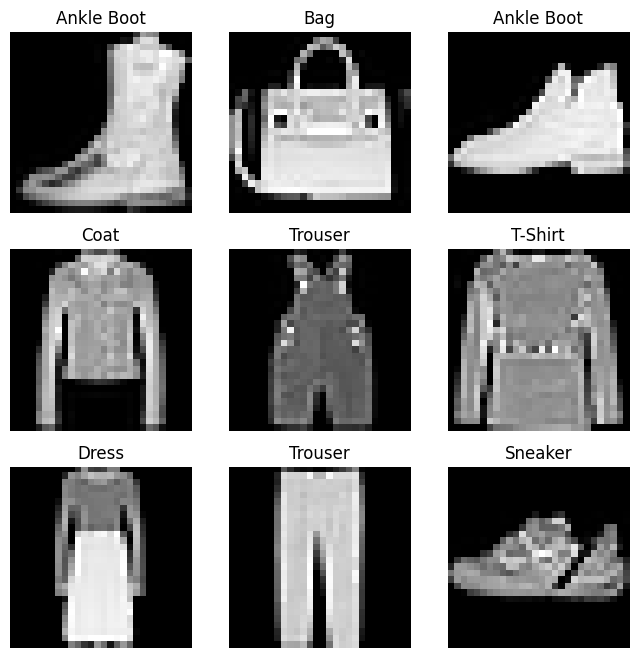

In [12]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()